In [ ]:
import sys, os, pandas as pd
sys.path.insert(0, os.path.abspath(".."))
from collections import defaultdict
from src.preprocess import split_improvements, parse_improvement, clean_text
from src.labels import labels_measure

FILE = "../data/raw/D_EPC_data_2025Q2/2015Q3.csv"  # adjust as needed
ID_COL, TEXT_COL = "REPORT_REFERENCE_NUMBER", "IMPROVEMENTS"

prop_texts, prop_labels = defaultdict(list), defaultdict(set)

for chunk in pd.read_csv(FILE, chunksize=50_000, low_memory=False, usecols=[ID_COL, TEXT_COL]):
    for rrn, txt in chunk[[ID_COL, TEXT_COL]].itertuples(index=False, name=None):
        if pd.isna(txt): 
            continue
        for seg in split_improvements(txt):
            rec = parse_improvement(seg)
            m = rec.get("measure")
            if not m: 
                continue
            prop_texts[rrn].append(m)
            prop_labels[rrn] |= labels_measure(m)

rows = []
for rrn, measures in prop_texts.items():
    labs = sorted(list(prop_labels[rrn]))
    if not labs: 
        continue
    rows.append({"rrn": rrn, "text_raw": " . ".join(measures), "labels": labs})

prop_df = pd.DataFrame(rows)
prop_df["text_clean"] = prop_df["text_raw"].map(clean_text)
prop_df.to_csv("../data/processed/epc_property_level.csv", index=False)
prop_df.head(3)


,rrn,text_raw,labels,text_clean
0,0120-2329-6030-9075-1045,"Solar photovoltaic panels, 2.5 kWp . Replace b...","[heating, insulation, lighting, renewables]",solar photovoltaic panels kwp replace boiler n...
1,1315-5023-2000-0479-0902,Room-in-roof insulation . Internal or external...,"[glazing, heating, insulation, lighting, renew...",room roof insulation internal external wall in...
2,2015-6028-9000-0234-0902,Replace boiler with new condensing boiler . So...,"[heating, hot_water, insulation, lighting, ren...",replace boiler new condensing boiler solar wat...


In [2]:
#Sanity check 
print(prop_df['text_raw'].iloc[0])
print(prop_df['text_clean'].iloc[0])

Solar photovoltaic panels, 2.5 kWp . Replace boiler with new condensing boiler . Floor insulation (suspended floor) . Low energy lighting for all fixed outlets . Solar water heating . Internal or external wall insulation
solar photovoltaic panels kwp replace boiler new condensing boiler floor insulation suspended floor low energy lighting fixed outlets solar water heating internal external wall insulation


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

prop_df = pd.read_csv("../data/processed/epc_property_level.csv")

# Keep a reasonable subset while iterating (increase later)
sub = prop_df.sample(n=min(len(prop_df), 120_000), random_state=42).reset_index(drop=True)

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(sub["labels"])
labels = list(mlb.classes_)  # ['glazing','heating','hot_water','insulation','lighting','renewables']

train_df, test_df, Y_train, Y_test = train_test_split(
    sub[["text_clean"]], Y, test_size=0.15, random_state=42
)

# Hugging Face Datasets
from datasets import Dataset
train_ds = Dataset.from_pandas(pd.DataFrame({"text": train_df["text_clean"], "labels": list(Y_train)}))
test_ds  = Dataset.from_pandas(pd.DataFrame({"text": test_df["text_clean"],  "labels": list(Y_test)}))
len(train_ds), len(test_ds), labels


/home/federicostachurski/epc-nlp-project/.npl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(22593,
 3988,
 [' ',
  "'",
  ',',
  '[',
  ']',
  '_',
  'a',
  'b',
  'e',
  'g',
  'h',
  'i',
  'l',
  'n',
  'o',
  'r',
  's',
  't',
  'u',
  'w',
  'z'])

In [7]:
#Tokenize + model (DistilBERT, multi-label)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Sequence, Value

model_name = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tok(batch["text"], truncation=True, max_length=192)


# if you already have train_ds / test_ds built with int labels:
train_ds = train_ds.cast_column("labels", Sequence(Value("float32")))
test_ds  = test_ds.cast_column("labels", Sequence(Value("float32")))

train_tok = train_ds.map(tokenize, batched=True, remove_columns=["text"])
test_tok  = test_ds.map(tokenize, batched=True, remove_columns=["text"])

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    problem_type="multi_label_classification"  # sigmoid + BCEWithLogitsLoss
)




Map: 100%|██████████| 3988/3988 [00:00<00:00, 36300.21 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# After adding the new tokes in the pre trained model (vocab size changed)
# now we cna tria nthe transformer model

from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import f1_score, jaccard_score, hamming_loss

def sigmoid(x): 
    return 1/(1+np.exp(-x))

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    # ensure ints for sklearn
    y_true = np.array(y_true).astype(int)

    y_prob = sigmoid(logits)
    y_pred = (y_prob >= 0.5).astype(int)  # simple threshold; you can tune later

    return {
        "f1_micro": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "jaccard_samples": jaccard_score(y_true, y_pred, average="samples"),
        "hamming_loss": hamming_loss(y_true, y_pred),
    }




args = TrainingArguments(
    output_dir="../models/epc_distilbert_multilabel",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,   # drop to 8/4 if OOM
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,                        # keep if your GPU supports it
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    tokenizer=tok,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("../models/epc_distilbert_multilabel/best")
tok.save_pretrained("../models/epc_distilbert_multilabel/best")


/tmp/ipykernel_8659/2884146055.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Jaccard Samples,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.001100,0.000598,0.999888,0.999899,0.999765,0.000179,1.776700,2244.657000,70.357000
2,0.000300,0.000237,0.999978,0.999982,0.999937,0.000036,2.007900,1986.194000,62.255000
3,0.000200,0.000186,0.999978,0.999982,0.999937,0.000036,2.075500,1921.451000,60.226000


('../models/epc_distilbert_multilabel/best/tokenizer_config.json',
 '../models/epc_distilbert_multilabel/best/special_tokens_map.json',
 '../models/epc_distilbert_multilabel/best/vocab.txt',
 '../models/epc_distilbert_multilabel/best/added_tokens.json',
 '../models/epc_distilbert_multilabel/best/tokenizer.json')

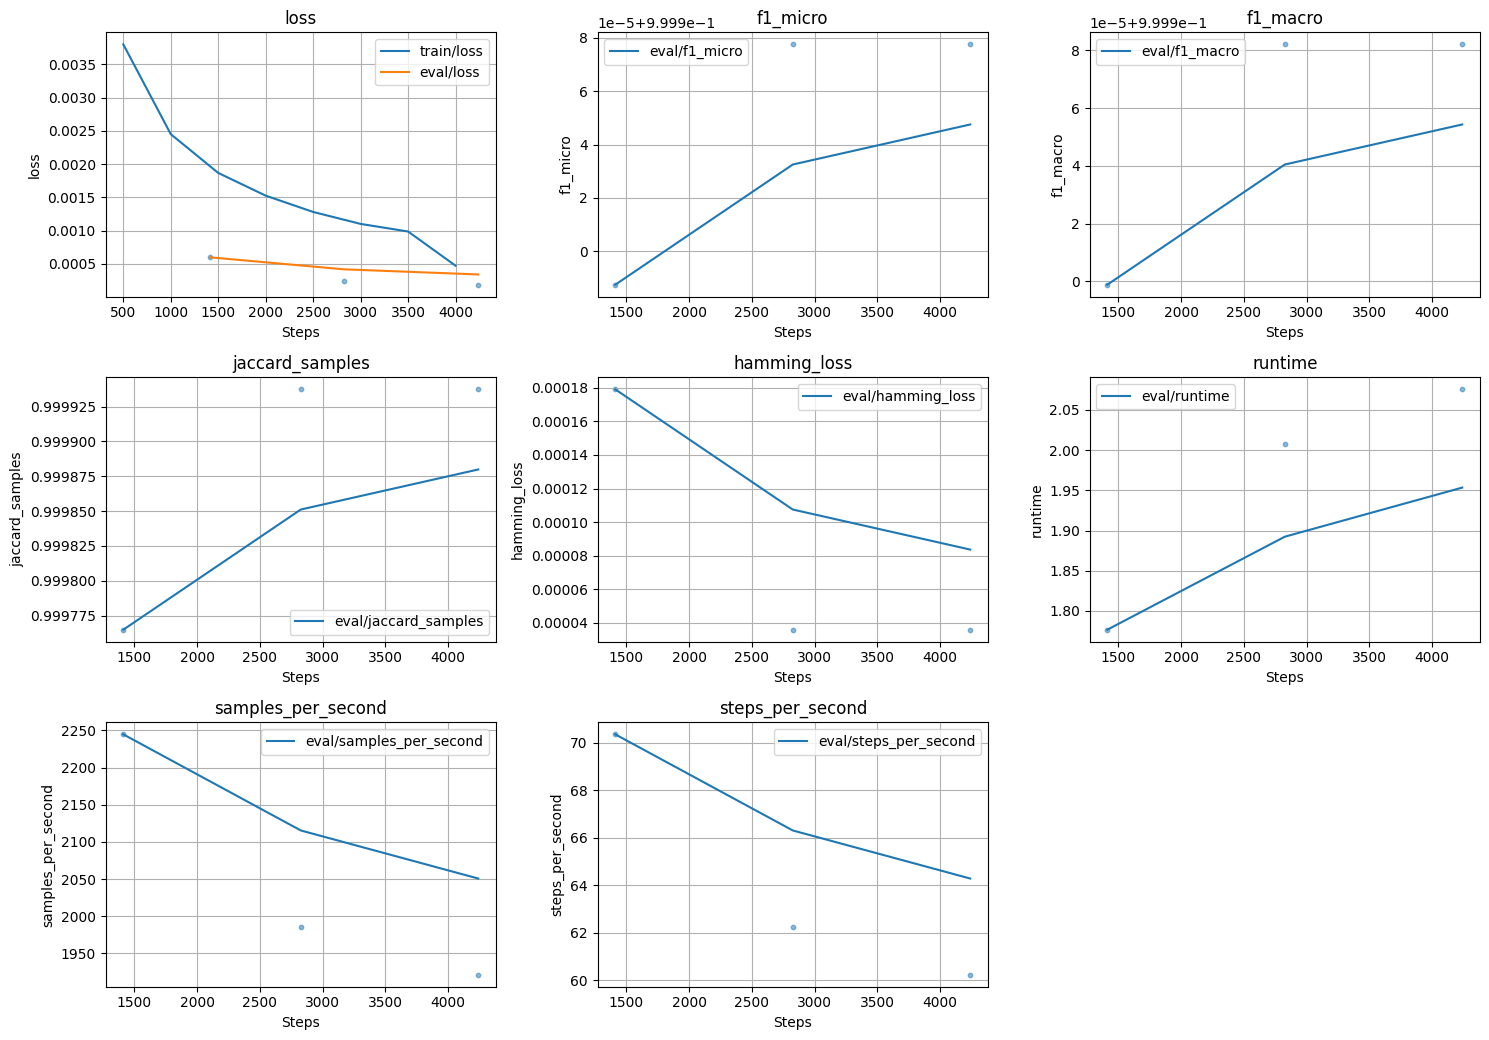

In [28]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Collect & tidy logs ----
logs = trainer.state.log_history

rows = []
for r in logs:
    step = r.get("step")
    if step is None:
        continue

    # training loss
    if "loss" in r:
        rows.append({"step": step, "split": "train", "metric": "loss", "value": r["loss"]})

    # eval metrics (appear only at eval steps)
    for k in r.keys():
        if k.startswith("eval_"):
            rows.append({"step": step, "split": "eval", "metric": k.replace("eval_", ""), "value": r[k]})

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No metrics found in log_history. Make sure evaluation/logging strategies are enabled.")

# Optional: smooth curves (moving average)
def smooth(series, window=5):
    if window <= 1:
        return series.values
    return series.rolling(window=window, min_periods=1, center=False).mean().values

# ---- Choose which metrics to plot (include only those present) ----
all_metrics = df["metric"].unique().tolist()
# Put common ones first if present
preferred_order = ["loss", "loss_val", "f1_micro", "f1_macro", "jaccard_samples", "hamming_loss"]
ordered = [m for m in preferred_order if m in all_metrics] + [m for m in all_metrics if m not in preferred_order]
metrics_to_plot = ordered

# ---- Make a grid of subplots (multi-plot) ----
n = len(metrics_to_plot)
cols = 3
rows_count = math.ceil(n / cols)
fig, axes = plt.subplots(rows_count, cols, figsize=(5*cols, 3.5*rows_count), squeeze=False)
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    # training curve (metric == 'loss')
    if metric == "loss":
        dtr = df[(df["metric"] == "loss") & (df["split"] == "train")].sort_values("step")
        if not dtr.empty:
            ax.plot(dtr["step"], smooth(dtr["value"], window=7), label="train/loss")
    # eval curve
    dev = df[(df["metric"] == metric) & (df["split"] == "eval")].sort_values("step")
    if not dev.empty:
        # show raw eval points and a smoothed line
        ax.plot(dev["step"], smooth(dev["value"], window=3), label=f"eval/{metric}")
        ax.scatter(dev["step"], dev["value"], s=10, alpha=0.5)

    ax.set_title(metric)
    ax.set_xlabel("Steps")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend(loc="best")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import jaccard_score

pred = trainer.predict(test_tok)
y_true = np.array(pred.label_ids).astype(int)
y_prob = 1/(1+np.exp(-pred.predictions))

ts = np.linspace(0.2, 0.8, 13)
best_t = ts[np.argmax([jaccard_score(y_true, (y_prob>=t).astype(int), average="samples") for t in ts])]
y_pred = (y_prob >= best_t).astype(int)
print("Best threshold:", best_t)


Best threshold: 0.35000000000000003


In [14]:
from sklearn.metrics import f1_score, jaccard_score, hamming_loss, classification_report
import numpy as np

# assuming you still have y_true and y_prob from predict()
t = 0.35
y_pred = (y_prob >= t).astype(int)

print("Hamming loss (more better):", hamming_loss(y_true, y_pred))
print("Jaccard (samples avg, more better):", jaccard_score(y_true, y_pred, average="samples"))
print("F1 micro:", f1_score(y_true, y_pred, average="micro", zero_division=0))
print("F1 macro:", f1_score(y_true, y_pred, average="macro", zero_division=0))

# per-class report
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))
y_pred_safe = y_pred.copy()
empty = y_pred_safe.sum(axis=1) == 0
top1 = y_prob[empty].argmax(axis=1)
y_pred_safe[empty, top1] = 1


Hamming loss (more better): 3.5821750967187274e-05
Jaccard (samples avg, more better): 0.9999373119358074
F1 micro: 0.9999775023060137
F1 macro: 0.9999820823851928
              precision    recall  f1-score   support

                   1.00      1.00      1.00      3331
           '       1.00      1.00      1.00      3988
           ,       1.00      1.00      1.00      3331
           [       1.00      1.00      1.00      3988
           ]       1.00      1.00      1.00      3988
           _       1.00      1.00      1.00       547
           a       1.00      1.00      1.00      3810
           b       1.00      1.00      1.00      2491
           e       1.00      1.00      1.00      3293
           g       1.00      1.00      1.00      3417
           h       1.00      1.00      1.00      3345
           i       1.00      1.00      1.00      3673
           l       1.00      1.00      1.00      3937
           n       1.00      1.00      1.00      3985
           o       1.00  

In [18]:
mlb.classes_

array([' ', "'", ',', '[', ']', '_', 'a', 'b', 'e', 'g', 'h', 'i', 'l',
       'n', 'o', 'r', 's', 't', 'u', 'w', 'z'], dtype=object)

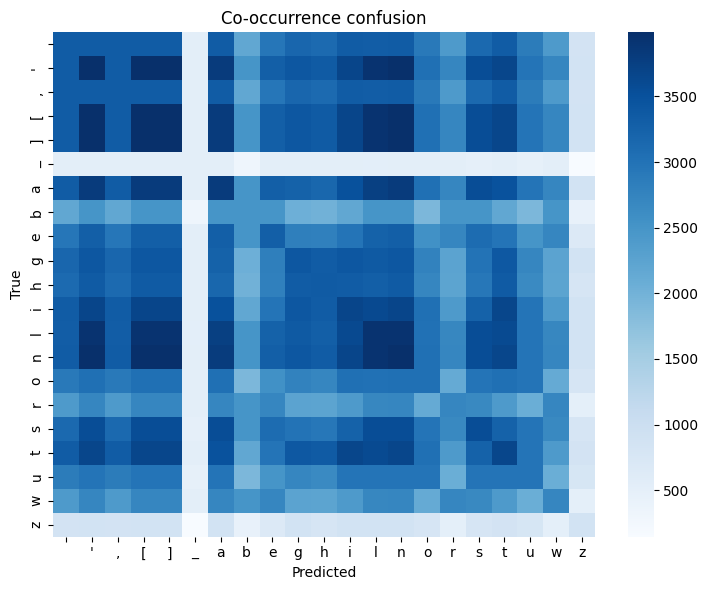

In [15]:
import seaborn as sns, matplotlib.pyplot as plt, numpy as np

cooc = np.zeros((len(labels), len(labels)), dtype=int)
for yt, yp in zip(y_true, y_pred):
    t_idx, p_idx = np.where(yt==1)[0], np.where(yp==1)[0]
    for t_i in t_idx:
        for p_i in p_idx:
            cooc[t_i, p_i] += 1

plt.figure(figsize=(7.5,6))
sns.heatmap(cooc, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Co-occurrence confusion"); plt.tight_layout(); plt.show()


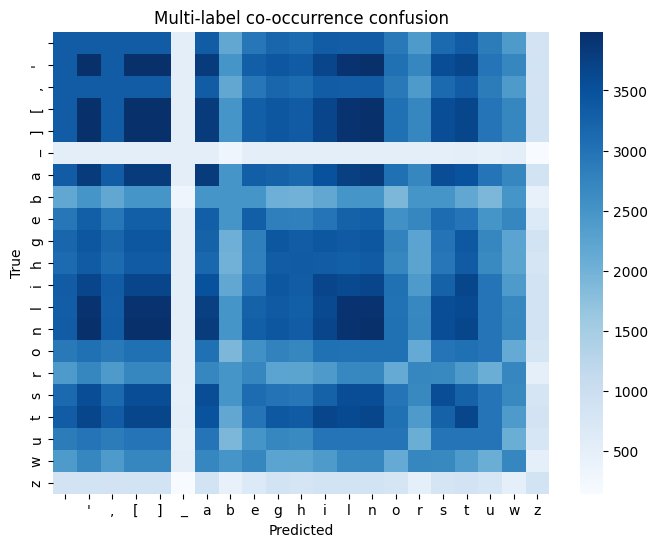

In [12]:
# build co-occurrence counts: true label vs predicted label
import matplotlib.pyplot as plt
import seaborn as sns


classes = mlb.classes_
cooc = np.zeros((len(classes), len(classes)), dtype=int)

for yt, yp in zip(y_true, y_pred):
    true_labels = np.where(yt==1)[0]
    pred_labels = np.where(yp==1)[0]
    for t in true_labels:
        for p in pred_labels:
            cooc[t, p] += 1

plt.figure(figsize=(8,6))
sns.heatmap(cooc, annot=False, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Multi-label co-occurrence confusion")
plt.show()